# Описание проекта 

Перейдём к задаче. HR-аналитики компании **«Работа с заботой»** помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 
У вас будет несколько задач. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.
Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.
Теперь расскажем подробнее о задачах.

## Задача 1

Для этой задачи заказчик предоставил данные с признаками:
+ **id** — уникальный идентификатор сотрудника;
+ **dept** — отдел, в котором работает сотрудник;
+ **level** — уровень занимаемой должности;
+ **workload** — уровень загруженности сотрудника;
+ **employment_years** — длительность работы в компании (в годах);
+ **last_year_promo** — показывает, было ли повышение за последний год;
+ **last_year_violations** — показывает, нарушал ли сотрудник трудовой договор за последний год;
+ **supervisor_evaluation** — оценка качества работы сотрудника, которую дал руководитель;
+ **salary** — ежемесячная зарплата сотрудника;
+ **job_satisfaction_rate** — уровень удовлетворённости сотрудника работой в компании, целевой признак.

## Загрузка и предобработка данных

In [1]:
pip install -U scikit-learn

     |████████████████████████████████| 13.4 MB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 51.2 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip -q install shap
!pip -q install phik

In [3]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import math
import numpy as np
import phik
import shap
from scipy import stats

In [4]:
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.tree import (DecisionTreeRegressor, DecisionTreeClassifier)
from sklearn.metrics import (mean_absolute_percentage_error, roc_auc_score, make_scorer)
from sklearn.linear_model import (LogisticRegression, LinearRegression)
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    RandomizedSearchCV, 
    GridSearchCV,
    KFold
)
from sklearn.preprocessing import (StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder, RobustScaler)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from warnings import simplefilter

In [5]:
simplefilter(action='ignore', category=FutureWarning)

In [6]:
train_job_stf_r = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
test_f = pd.read_csv('/datasets/test_features.csv')
test_trg_job_stf = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

### Предобработка train_job_satisfaction_rate

In [7]:
display(train_job_stf_r.head(5))
train_job_stf_r.describe()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


Данные выглядят приемлемо, распределение тоже не вызывает вопросов

In [8]:
train_job_stf_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


+ Все типы данных поставлены в соотвествии с данными, которые хранят столбцы
+ Можем обнаружить очень небольшое кол-во пропусков в столбцах **dept** и **level**

Проанализируем датафрейм на налиичие дубликатов

In [9]:
train_job_stf_r.duplicated().sum()

0

Явных дубликатов нет, посмотрим на неявные

In [10]:
list = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

In [11]:
for i in list:
    print(train_job_stf_r[i].unique())

['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
['junior' 'middle' 'sinior' nan]
['medium' 'high' 'low']
['no' 'yes']
['no' 'yes']


In [12]:
train_job_stf_r['level'] = train_job_stf_r.level.replace('sinior', 'senior')

Неявных дубликатов не обнаружено

### Предобработка test_features

In [13]:
display(test_f.head(5))
test_f.describe()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


In [14]:
test_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


У всех столбцов правильные типы данных и небольшое кол-во пропусков

Проверим на дубликаты

In [15]:
test_f.duplicated().sum()

0

Опять же, явных дубликатов нет, посмотрим неявные

In [16]:
list = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
for i in list:
    print(test_f[i].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' ' ']
['no' 'yes']
['no' 'yes']


Можем заметить помимо обычных опечаток и пропусков (**nan**) пробелы, устраним их 

In [17]:
test_f.level = test_f.level.replace('sinior', 'senior')

In [18]:
test_f['dept'] = test_f['dept'].replace(' ', np.nan) 
test_f['workload'] = test_f['workload'].replace(' ', np.nan) 

По сути на этом работа с данными практически закончена, тееперь нам надо заполнить пропуски с помощью пайнплайна

In [19]:
train_job_df_no_rate = train_job_stf_r.drop(columns=('job_satisfaction_rate'))

## Исследовательский анализ данных

### train выборка

Сначала взглянем на графическое распределение категориальных признаков

In [20]:
def obj_graph(df):
    list = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
    plt.figure(figsize=(16, 12)) 
    
    count = 1
    for i in list:
        plt.subplot(3, 2, count)  
        sns.countplot(y=i, data=df)
        plt.title(f'Рапределение по {i}', fontsize=16)
        plt.xlabel('Количество', fontsize=14)
        count += 1
    plt.tight_layout() 
    plt.show()

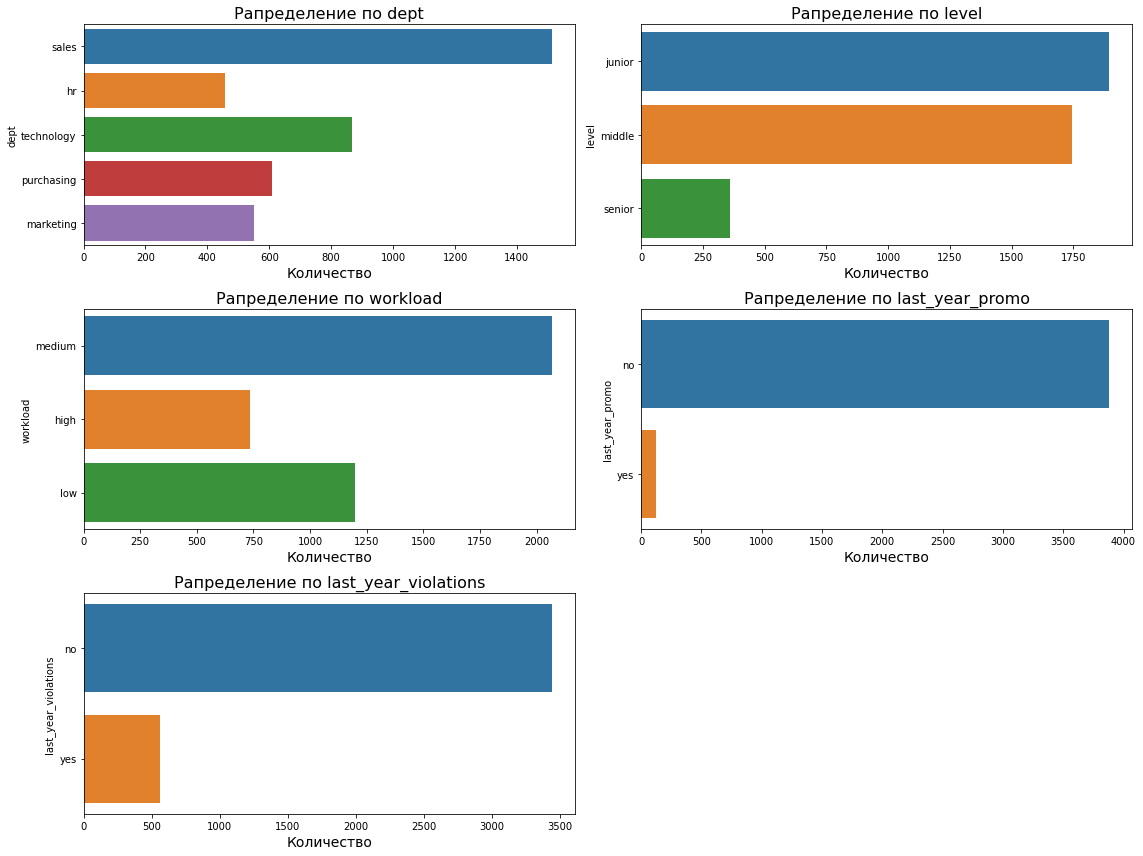

In [21]:
obj_graph(train_job_stf_r)

+ Наибольший по числу работников отдел - **отдел продаж (sales)**, затем идет отдел **technology** и замыкает тройку **purchasing**
+ Число специалистов квалификации **junior** и **middle** почти одинаковое, несоизмеримо меньше специалстов уровня **senior**
+ Преимущественно у сотрудников **средняя загруженность**, работников с **высокой загруженностью** значительно меньше
+ Ожидаемо, работников, у которых было повышение за последний год разительно меньше, чем тех, кто получал повышение
+ Сотрудников, которые нарушали трудовой договор чуть больше 500, это довольно мало относительно общего числа работников 

Теперь перейдем к количественным признакам

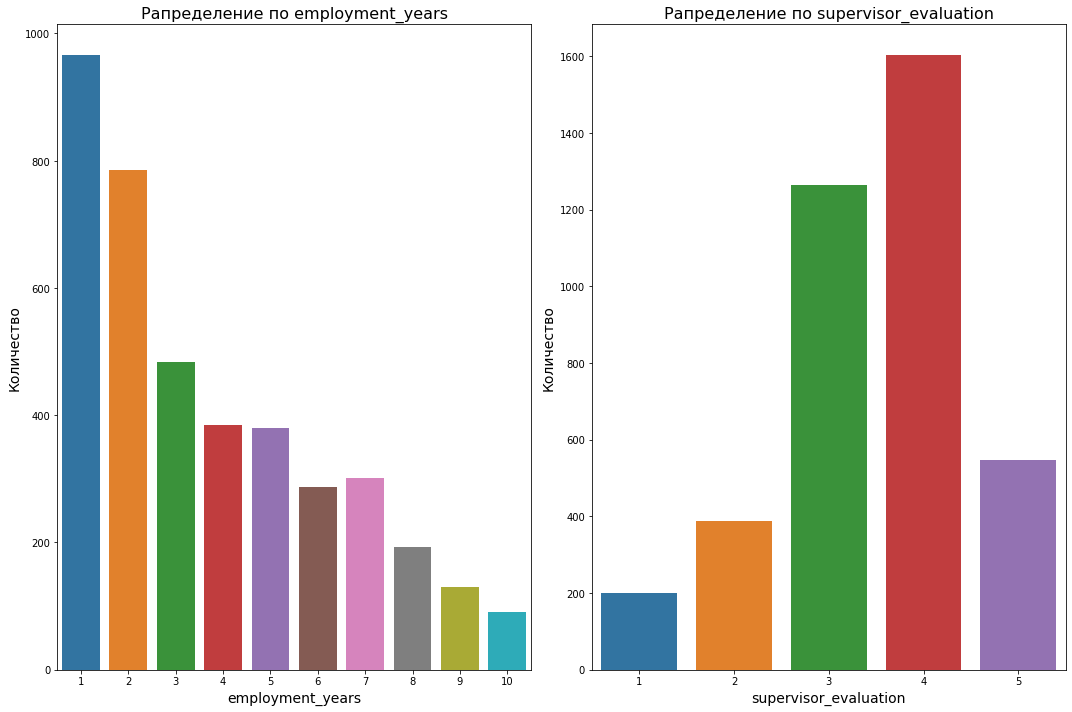

In [22]:
list = ['employment_years', 'supervisor_evaluation']
plt.figure(figsize=(15, 10)) 
count = 1
for i in list:
    plt.subplot(1, 2, count)  
    sns.countplot(x=i, data=train_job_stf_r)
    plt.title(f'Рапределение по {i}', fontsize=16)
    plt.xlabel(i, fontsize=14)
    plt.ylabel('Количество', fontsize=14)
    count += 1

plt.tight_layout() 
plt.show()

+ Что логично, абсолютное большинство сотрудников имеет стаж **1 год**, далее кол-во сотрудников падает пропорционально повышению рабочего стажа
+ Преимущественно работодатель оценивает сотрдуников на **4** балла, чуть реже на **3** и только затем идет **5**

In [23]:
def graph(df, i):
    plt.figure(figsize=(16, 12))  
    sns.histplot(df, bins = 35, kde = True, x = i)
    plt.title(f'Рапределение по периоду', fontsize=16)
    plt.xlabel('количество', fontsize=14)
    plt.tight_layout() 
    plt.show()

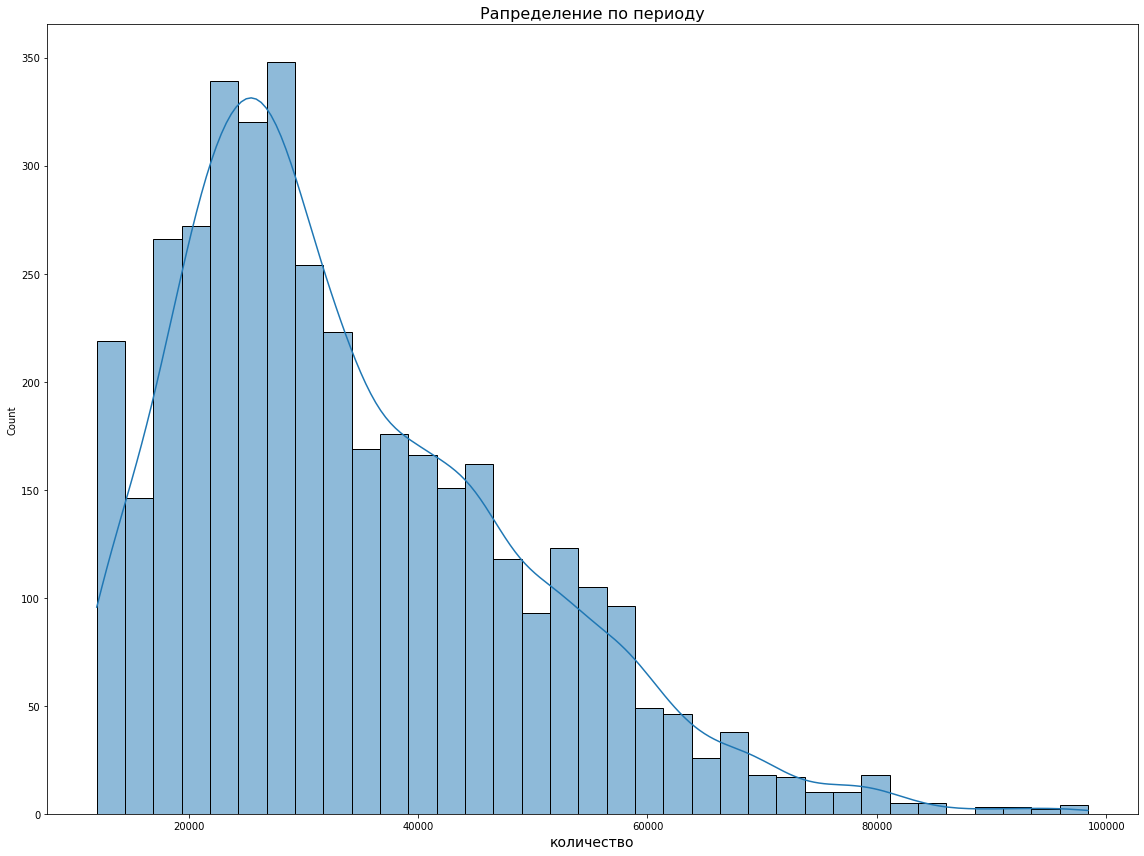

In [24]:
graph(train_job_stf_r, 'salary')

Доход большинства сотрудников начинается от **20000** и доходит до **40000**. Можем даже построить **boxplot**, чтобы более подробно рассмотреть распределение зарплат 

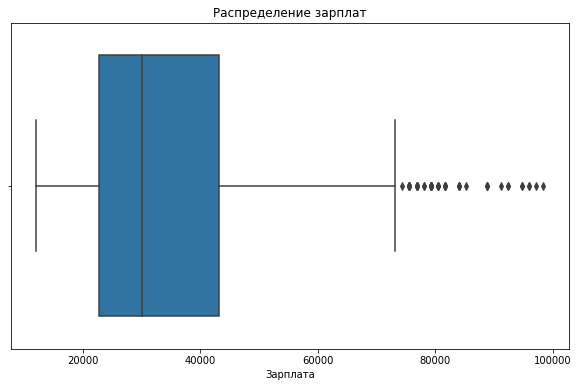

In [25]:
plt.rcParams["figure.figsize"] = (10, 6)

sns.boxplot(x='salary', data=train_job_stf_r);
plt.xlabel('Зарплата');
plt.title('Распределение зарплат');
plt.show()

График подтверждает наши выводы. Также мы видим, что все что превышает **75000**, является аномалией

Посмотрим и на распределение нашего целевого признака

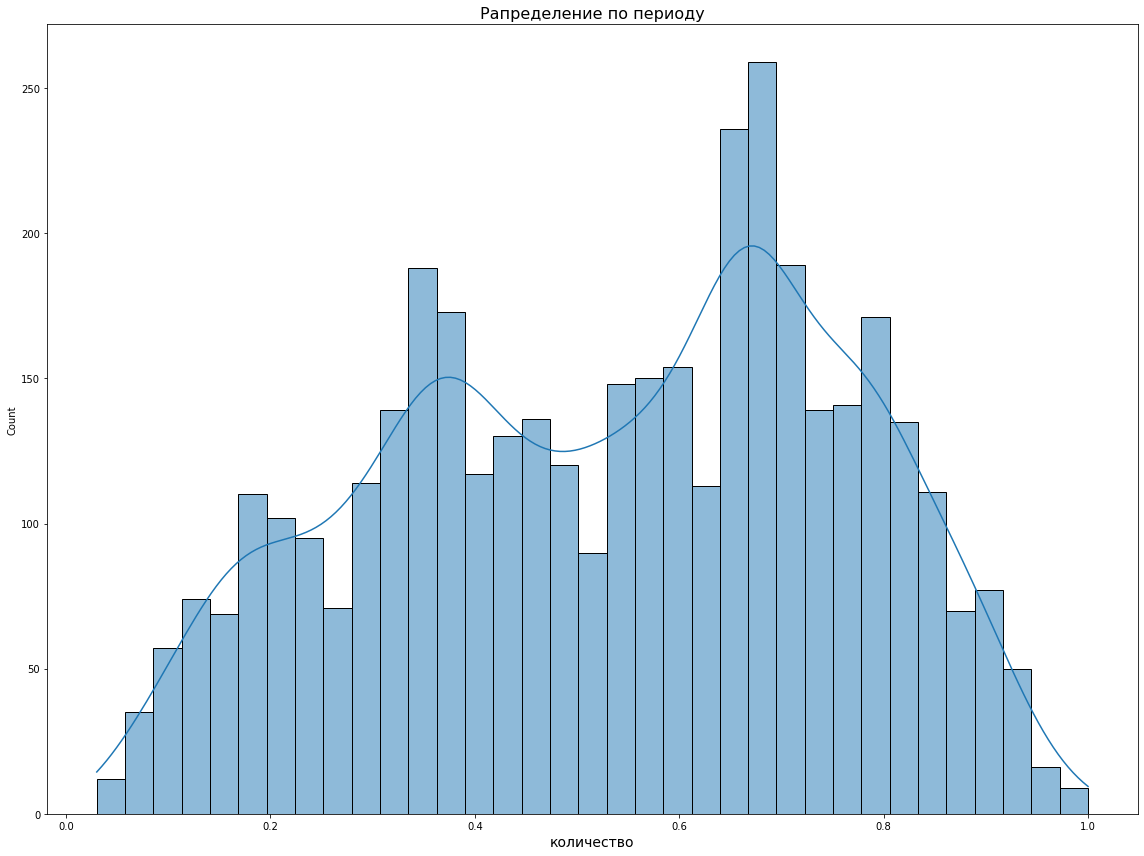

In [26]:
graph(train_job_stf_r, 'job_satisfaction_rate')

Можем заметить тренд роста до **0.4**, затем идет небольшой спад, затем пиковый рост достигается в **0.7**, после чего начинается стремительный спад

Теперь взглянем на матрицу корелляции, оценивать будет только относительно целевого признака - **job_satisfaction_rate**

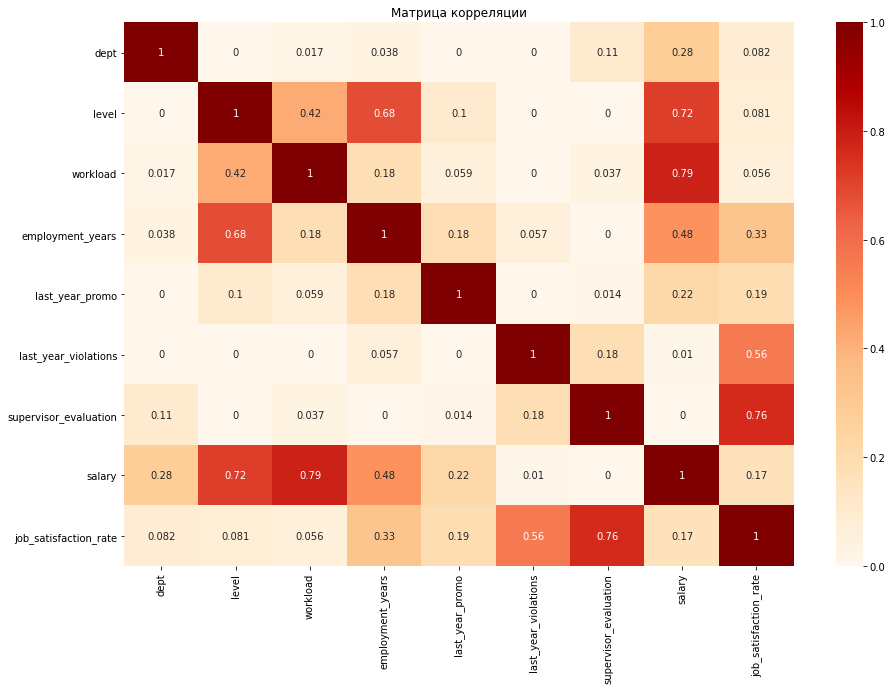

In [27]:
train_job_stf_r = train_job_stf_r.drop('id', axis=1)

interval_cols = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate'] 

corr_matrix = train_job_stf_r.phik_matrix(interval_cols=interval_cols)

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='OrRd')
plt.title('Матрица корреляции')
plt.show()

### test выборка

Визуализируем все то же, что и для **train** выборки, посмотрим будут ли данные отличаться 

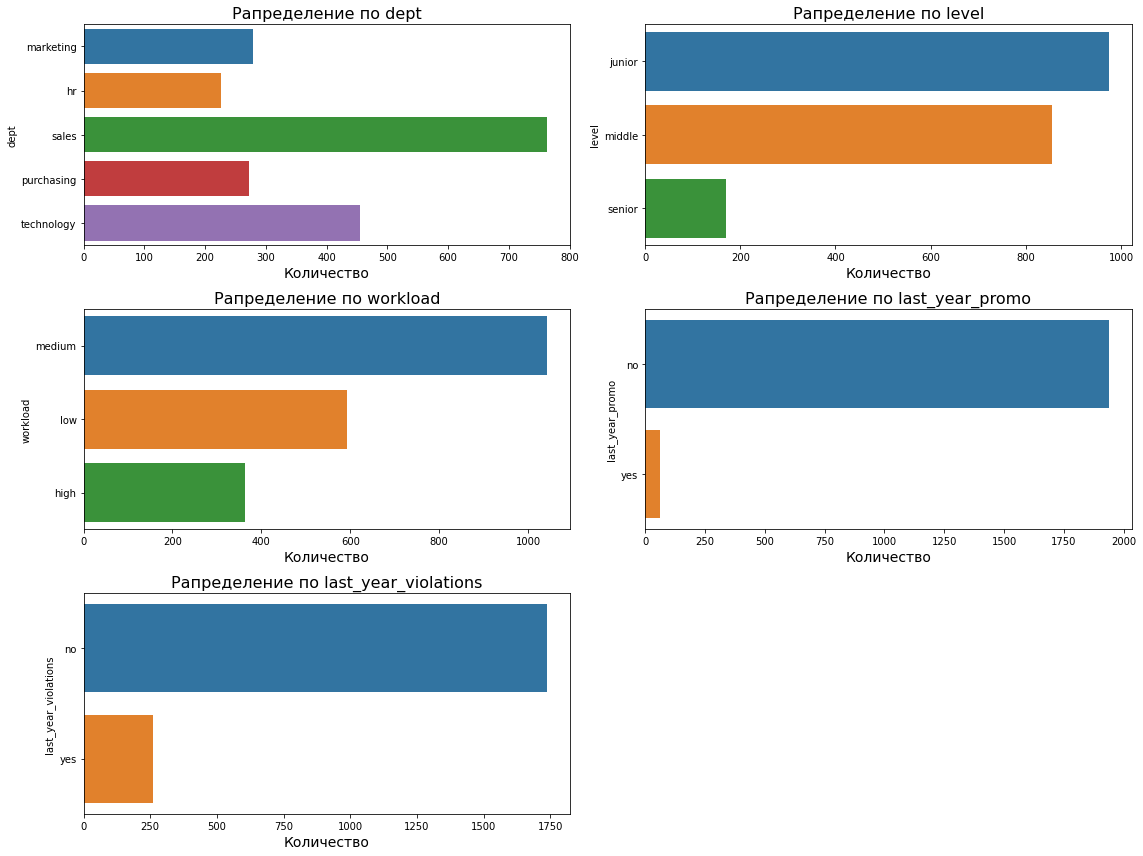

In [28]:
obj_graph(test_f)

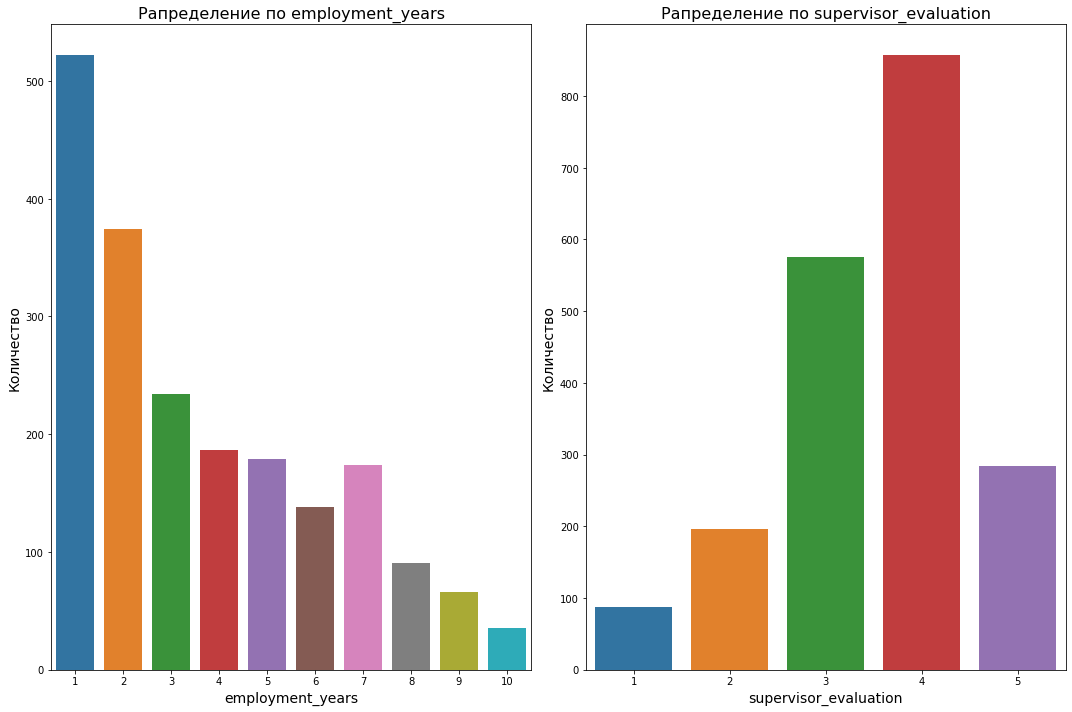

In [29]:
list = ['employment_years', 'supervisor_evaluation']
plt.figure(figsize=(15, 10)) 
count = 1
for i in list:
    plt.subplot(1, 2, count)  
    sns.countplot(x=i, data=test_f)
    plt.title(f'Рапределение по {i}', fontsize=16)
    plt.xlabel(i, fontsize=14)
    plt.ylabel('Количество', fontsize=14)
    count += 1

plt.tight_layout() 
plt.show()

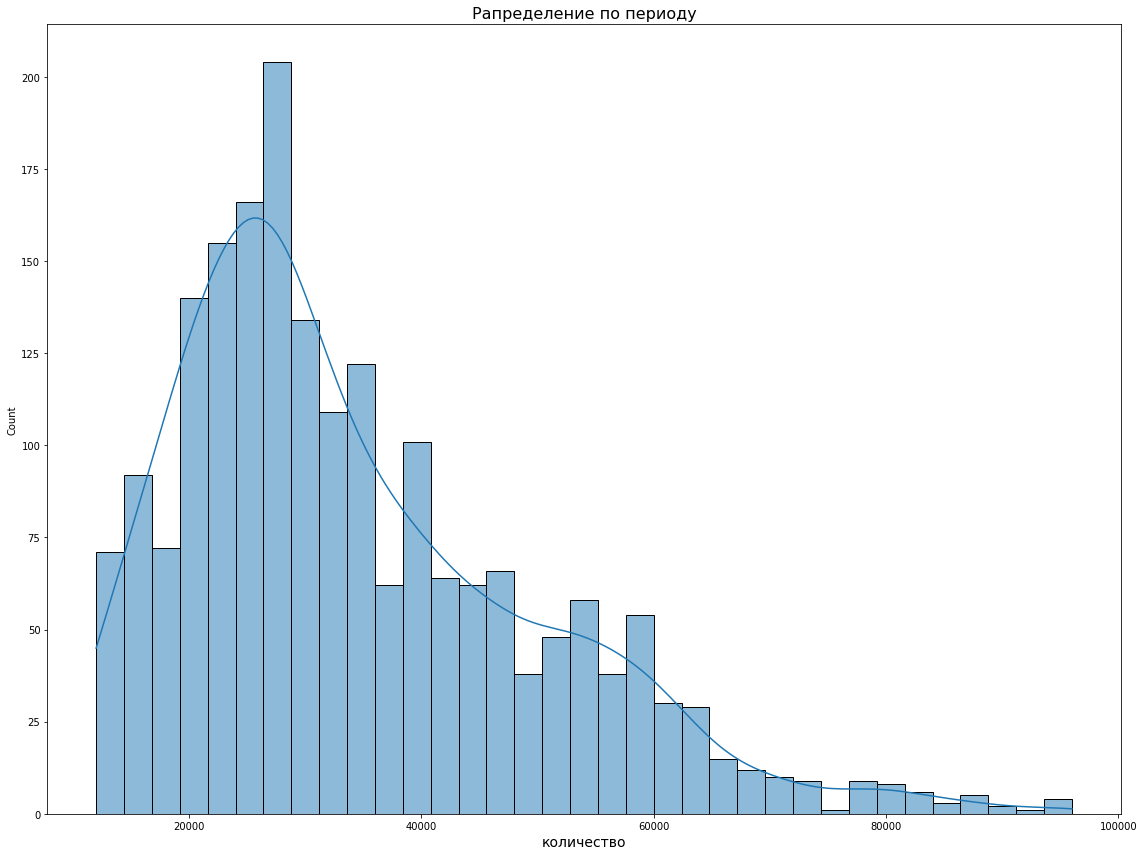

In [30]:
graph(test_f, 'salary')

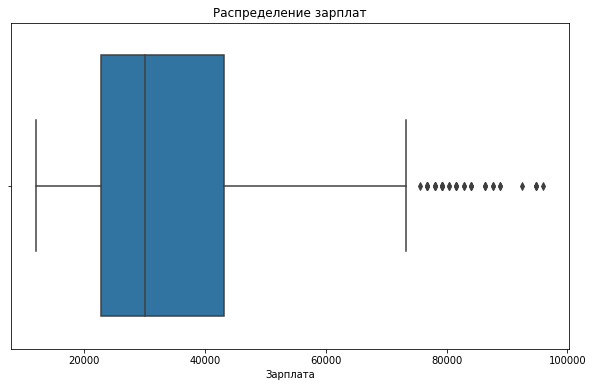

In [31]:
plt.rcParams["figure.figsize"] = (10, 6)

sns.boxplot(x='salary', data=test_f);
plt.xlabel('Зарплата');
plt.title('Распределение зарплат');
plt.show()

Распределение признаков **тестовой выборки** не отличается от распределения **тренировочной выборки**

Теперь взглянем на матрицу корелляции 

In [32]:
test_f_copy = test_f.copy()

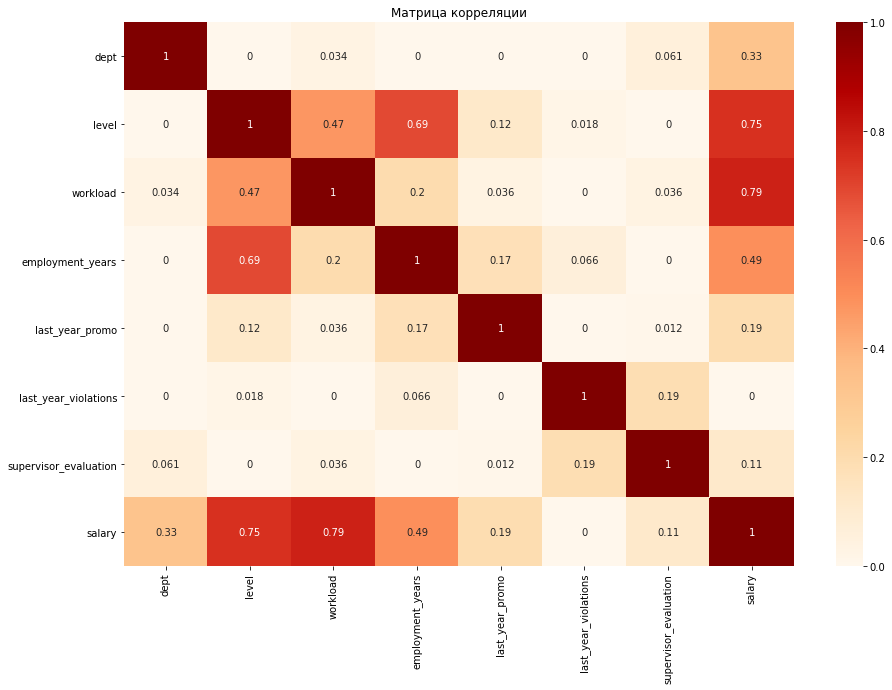

In [33]:
test_f_copy = test_f_copy.drop('id', axis=1)

interval_cols = ['salary', 'job_satisfaction_rate'] 
corr_matrix = test_f_copy.phik_matrix(interval_cols=interval_cols)

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='OrRd')
plt.title('Матрица корреляции')
plt.show()

### Вывод 

Уровень удовлетворенности работы и оценка руководителя **(job_satisfaction_rate** и **supervisor_evaluation):** Существует значительная положительная корреляция **(0.76)**, что может означать, что высокая оценка руководителя сильно связана с высокой удовлетворенностью работой сотрудников.

Удовлетворенность работы и наличие нарушений в прошлом году **(job_satisfaction_rate** и **last_year_violations):** Между этими параметрами также наблюдается существенная положительная корреляция **(0.56)**, что указывает на то, что отсутствие нарушений может быть связано с более высокой удовлетворенностью работой.

Зарплата и рабочая нагрузка **(salary** и **workload):** Здесь корреляция составляет **(0.79)**, что является одним из самых сильных показателей связи в данной матрице. Это может свидетельствовать о том, что сотрудники с более высоким уровнем зарплаты обычно испытывают большую рабочую нагрузку.

Зарплата и уровень должности **(salary** и **level):** Эти переменные имеют корреляцию **(0.72)**, подчеркивая ожидаемую связь между более высокой зарплатой и более высоким карьерным уровнем внутри компании.

Длительность работы и уровень должности **(employment_years** и **level):** Наблюдается достаточно сильная положительная корреляция в **(0.69)**, что может указывать на то, что сотрудники на более высоких должностях, как правило, дольше работают в компании.

## Подготовка данных

Теперь нам необходимо организовать данные перед обучением. Для начала сформируем полную тестовую выборку (из исходной тестовой выборки и отдельного датафрейма целевого признака) для дальнейшего обучения модели

In [34]:
all_test_f = pd.merge(test_f, test_trg_job_stf, on='id', how='inner')

Сделаем индекс в обоих датафреймах индексом, чтобы он не мешал при обучении модели

In [35]:
all_test_f = all_test_f.set_index('id')

Удаление дубликатов из тренировочной выборки после удаления **id**

In [36]:
train_job_stf_r.duplicated().sum()

245

In [37]:
train_job_stf_r = train_job_stf_r.drop_duplicates()

Теперь нам следует заполнить пропуски, закодировать категориальные признаки, а также учесть порядковые признаки **level** и **workload**

In [38]:
RANDOM_STATE = 42

In [39]:
X_train = train_job_stf_r.drop(['job_satisfaction_rate'], axis=1)
y_train = train_job_stf_r["job_satisfaction_rate"]

X_test = all_test_f.drop(['job_satisfaction_rate'], axis=1)
y_test = all_test_f['job_satisfaction_rate']

In [40]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations'] 
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

In [41]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
)

In [42]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'], 
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),

    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

### Вывод

Выполнена подготовка данных для обучения модели:

**Признаки**
+ Разделены признаки и целевая переменная для обучающего и тестового наборов данных.
+ Выделены столбцы для категориальных и числовых признаков.
+ Созданы шаги для предобработки данных в пайплайне:

**Кодирование**
+ Для категориальных признаков использованы кодировщики OneHotEncoder и OrdinalEncoder с соответствующими параметрами.
+ Для числовых признаков применено масштабирование с помощью StandardScaler.
+ Все преобразования объединены в ColumnTransformer.
+ Построен пайплайн для предобработки данных:

**Объединение**
+ Преобразования данных объединены в пайплайн Pipeline с преобразователем preprocessor.
+ Применена предобработка данных к обучающему и тестовому наборам:


## Обучение модели

In [43]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])
 
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 14),
        'models__max_features': range(5, 14),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    {
        'models' : [LinearRegression(n_jobs=-1)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    }
    
]
param_grid

[{'models': [DecisionTreeRegressor(random_state=42)],
  'models__max_depth': range(5, 14),
  'models__max_features': range(5, 14),
  'preprocessor__num': [StandardScaler(),
   MinMaxScaler(),
   RobustScaler(),
   'passthrough']},
 {'models': [LinearRegression(n_jobs=-1)],
  'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}]

In [44]:
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

In [45]:
smape_scorer = make_scorer(smape, greater_is_better=False)

In [46]:
kf_cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    n_iter=100,
    cv=kf_cv,
    scoring=smape_scorer,
    n_jobs=-1,
    random_state=RANDOM_STATE
)
grid_search.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year...
                                         'models__max_depth': range(5, 14),
                                         'models__max_features': range(5, 14),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [LinearRegression(n_jobs=-1)],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [47]:
best_model = grid_search.best_estimator_
print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', grid_search.best_score_*(-1))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                   

In [48]:
best_model = grid_search.best_estimator_
best_model_best_score = -grid_search.best_score_
best_model_best_score

15.855243080225932

In [49]:
best_model = grid_search.best_estimator_
print(f'Метрика sMAPE лучшей модели по кросс-валидации на обучающих данных: {round(grid_search.best_score_*(-1),4)}')

Метрика sMAPE лучшей модели по кросс-валидации на обучающих данных: 15.8552


In [50]:
print(f'Метрика sMAPE лучшей модели на тестовой выборке: {round(smape(y_test, best_model.predict(X_test)),4)}')

Метрика sMAPE лучшей модели на тестовой выборке: 14.3801


Проведем простейшую проверку на адекватность, используем для этого **DummyRegressor**. Выбранная модель значительно превосходит базовую стратегию предсказания, предложенную **DummyRegressor**, по всем ключевым метрикам качества

In [51]:
dummy_model = DummyRegressor()

dummy_model.fit(X_train, y_train)
dummy_model_preds = dummy_model.predict(X_test)

print(f'Метрика SMAPE dummy: {smape(y_test, dummy_model_preds)}')
print(f'Метрика SMAPE на тестовой выборке: {smape(y_test, best_model.predict(X_test))}')

Метрика SMAPE dummy: 38.26225790202238
Метрика SMAPE на тестовой выборке: 14.380135080572849


### Вывод

Мы использовали в **пайплайне** две модели машинного обучения - **LinearRegression** и **DecisionTreeRegressor**, в данном случае наилучшей оказалась модель **DecisionTreeRegressor** с гиперпараметрами **(max_depth=12, max_features=10,  random_state=42)**. На **тренировочной выборке** метрика **SMAPE** составила около **15.23%**, что свидетельствует о довольно хорошей способности модели аппроксимировать тренировочные данные. На **тестовой выборке** метрика составляет около **14.41%**, что указывает на хорошую способность модели к обобщению и прогнозированию на новых данных. Разница между показателями на тренировочной и тестовой выборке минимальна, что свидетельствует об отсутствии переобучения  

In [52]:
def model_predict(data):
    return grid_search.best_estimator_.named_steps['models'].predict(data)

X_train_pipe = pipe_final.named_steps['preprocessor'].fit_transform(X_train)

# Создаем фоновую выборку для объяснения
background_summary_pipe = shap.sample(X_train_pipe, nsamples=3, random_state=RANDOM_STATE)

explainer_pipe = shap.KernelExplainer(model_predict, background_summary_pipe)

X_test_pipe = pipe_final.named_steps['preprocessor'].transform(X_test)

feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()

X_test_pipe = pd.DataFrame(X_test_pipe, columns=feature_names)

shap_values_pipe = explainer_pipe(X_test_pipe)

  0%|          | 0/2000 [00:00<?, ?it/s]

Также мы можем оценить важность признаков с помощью метода **SHAP**

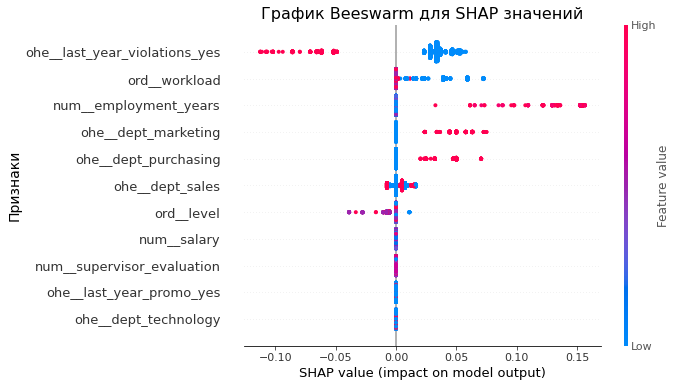

In [53]:
plt.xlabel("SHAP значения", fontsize=14)
plt.ylabel("Признаки", fontsize=14)
plt.title("График Beeswarm для SHAP значений", fontsize=16)

plt.style.use("ggplot")

plt.show(shap.plots.beeswarm(shap_values_pipe, max_display=12))

**supervisor_evaluation:** Оценка руководителем также является важным фактором. Более высокие оценки обеспечивают предсказанную высокую удовлетворенность работой, в ином случае ситуация противоположная

**salary:** Зарплата тоже является очень значимым признаком, чем выше зарплата - тем выше удовлетворенность сотрудника

**employment_years:** Чем ниже стаж, тем выше удовлетворенность сотрудника

**last_year_violations_yes:** Наличие нарушений в прошлом году оказывает отрицательное влияние на результаты модели. Чем выше значение этого признака (то есть если сотрудник имел нарушения), тем ниже предсказание удовлетворенности работы

**level:** Уровень сотрудника имеет значительное положительное влияние на результаты модели. Высококвалифицированные сотрудники, как предполагает модель, имеют более высокую удовлетворенность работой

**workload:** Рабочая нагрузка имеет разнонаправленное влияние на результаты модели, но можно заметить тенденцию к более низкой удовлетворенности при увеличении нагрузки.

**employment_years, dept_technology, dept_sales, и dept_marketing:** Стаж работы, а также принадлежность к определенным департаментам (технологии, продажи, маркетинг) оказывают меньшее влияние на удовлетворенность работой по сравнению с предыдущими признаками.



### Оформление выводов 

Для поиска лучшей модели были предприняты следующие шаги:

+ Проведено исследование полученных даных и признаков
+ В процессе поиска к данным применено 2 типа моделей классифкации
+ На основе метрики SMAPE была отобрана лучшая модель **('models', (max_depth=12, max_features=10, random_state=42** c использованием пайплайна
+ Метрика **SMAPE** лучшей модели на тренировочной выборке составила: **14.4118**
+ Наибольшее влияние на работу модели оказывают признаки **supervisor_evaluation, salary** и **employment_years**

## Загрузка данных

In [54]:
test_features = pd.read_csv('/datasets/test_features.csv')
train_quit = pd.read_csv('/datasets/train_quit.csv')
test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')

In [55]:
display(test_features.head(5))
test_features.describe().T

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.2135,253851.326129,100298.0,339052.0,550793.0,765763.75,999029.0
employment_years,2000.0,3.6665,2.537222,1.0,1.0,3.0,6.00,10.0
supervisor_evaluation,2000.0,3.5265,0.996892,1.0,3.0,4.0,4.00,5.0
salary,2000.0,34066.8000,15398.436729,12000.0,22800.0,30000.0,43200.00,96000.0


In [56]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


По аналогии с предыдущим заданием, пропусков здесь немного, устарним мы их уже на этапе проектирования пайплайна, распределение данных тоже не вызывает вопросов 

Перейдем к следующему датафрейму

In [57]:
display(train_quit.head(5))
train_quit.describe().T

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


,count,mean,std,min,25%,50%,75%,max
id,4000.0,552099.28375,260158.031387,100222.0,327785.75,546673.0,781497.75,999915.0
employment_years,4000.0,3.70150,2.541852,1.0,2.00,3.0,6.00,10.0
supervisor_evaluation,4000.0,3.47475,1.004049,1.0,3.00,4.0,4.00,5.0
salary,4000.0,33805.80000,15152.415163,12000.0,22800.00,30000.0,43200.00,96000.0


In [58]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


Здесь пропусков нет, все типы данных расставлены верно, распределение тоже смотрится адекватно

На всякий случай оценим датафрейм с целевым признаком

In [59]:
display(test_target_quit.head())
test_target_quit.info()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Все в порядке, поищим в данных дубликаты

In [60]:
test_features.duplicated().sum()

0

Явных дубликатов нет, взглянем на неявные

In [61]:
list_tf = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
for i in list_tf:
    print(test_features[i].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' ' ']
['no' 'yes']
['no' 'yes']


Вновь опечатки и пропуски, исправим это

In [62]:
test_features['dept'] = test_features['dept'].replace(' ', np.nan) 
test_features['workload'] = test_features['workload'].replace(' ', np.nan) 

In [63]:
test_features.level = test_features.level.replace('sinior', 'senior')

Теперь оценим датафрейм **train_quit**, где проводем аналогичные предыдущим процедуры и комментарии уже излишни

In [64]:
train_quit.duplicated().sum()

0

In [65]:
for i in list_tf:
    print(train_quit[i].unique())

['sales' 'purchasing' 'marketing' 'technology' 'hr']
['middle' 'junior' 'sinior']
['high' 'medium' 'low']
['no' 'yes']
['no' 'yes']


In [66]:
train_quit.level = train_quit.level.replace('sinior', 'senior')

На этом можно считать предобработку законченной, переходим к следующему этапу 

## Исследовательский анализ данных

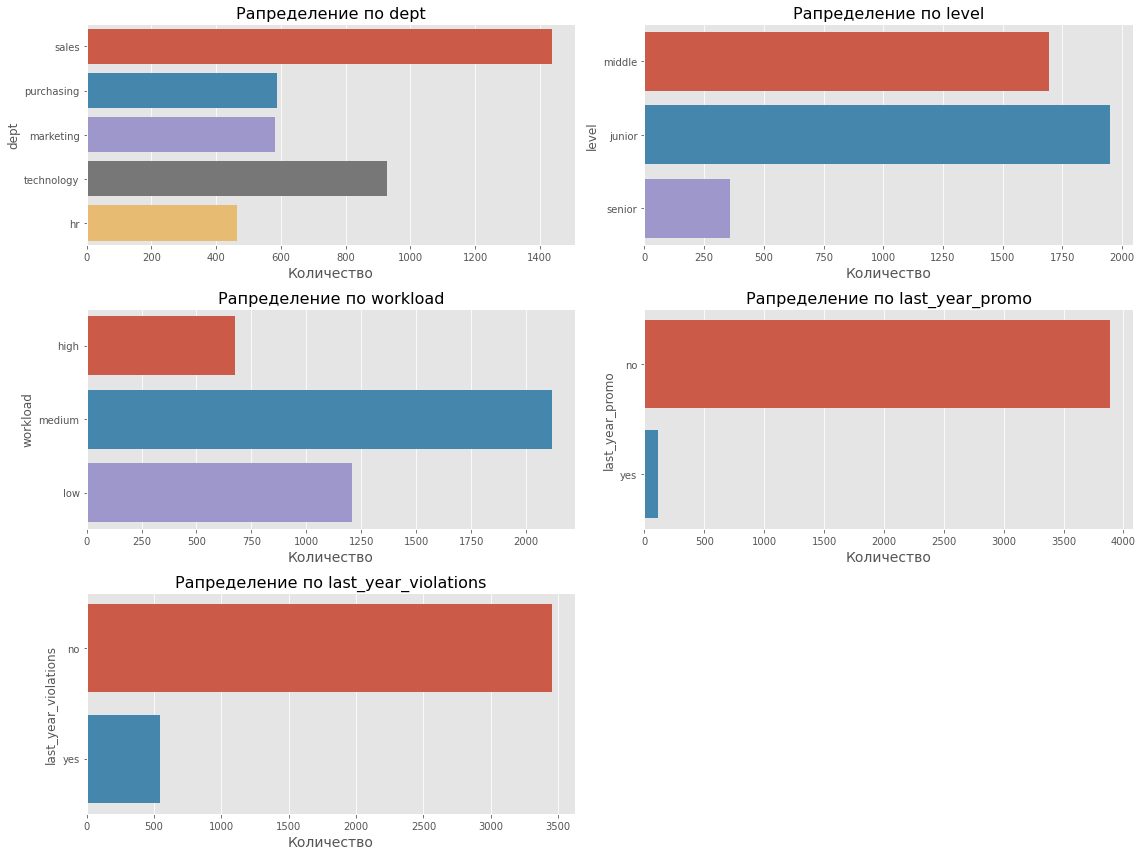

In [67]:
obj_graph(train_quit)

+ Наибольший по числу работников отдел - отдел продаж (sales), затем идет отдел technology, на третьем месте располагаются отделы **marketing** и **purchasing**
+ Число специалистов квалификации junior и middle почти одинаково **middle** специалистов незначительно меньше, несоизмеримо меньше специалстов уровня senior
+ Преимущественно у сотрудников средняя загруженность, работников с высокой загруженностью значительно меньше
+ Ожидаемо, работников, у которых было повышение за последний год разительно меньше, чем те, кто получал повышение
+ Сотрудников, которые нарушали трудовой договор **500**, это довольно мало относительно общего числа работников

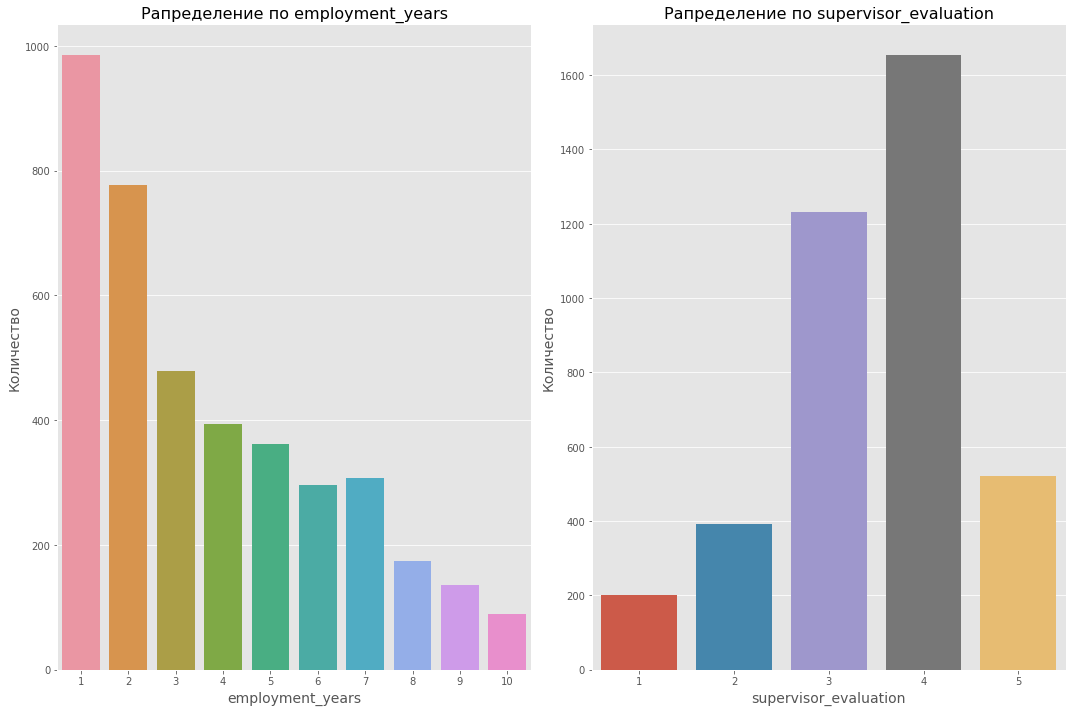

In [68]:
list = ['employment_years', 'supervisor_evaluation']
plt.figure(figsize=(15, 10)) 
count = 1
for i in list:
    plt.subplot(1, 2, count)  
    sns.countplot(x=i, data=train_quit)
    plt.title(f'Рапределение по {i}', fontsize=16)
    plt.xlabel(i, fontsize=14)
    plt.ylabel('Количество', fontsize=14)
    count += 1

plt.tight_layout() 
plt.show()

Ничего нового сказать нельзя
+ Абсолютное большинство сотрудников имеет стаж 1 год, далее кол-во сотрудников падает пропорционально повышению рабочего стажа
+ Преимущественно работодатель оценивает сотрдуников на 4 балла, чуть реже на 3 и только затем идет 5

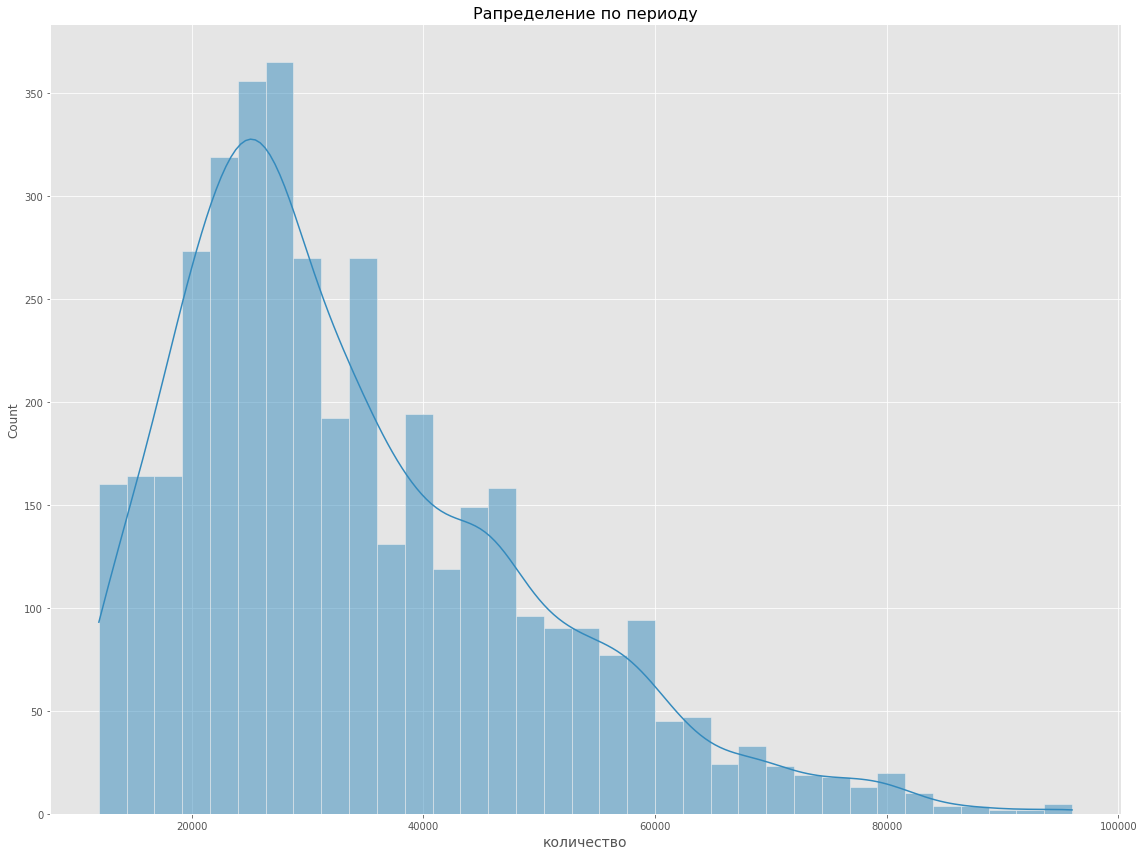

In [69]:
graph(train_quit, 'salary')

Картина аналогична тому, что мы видели в **задаче 1**

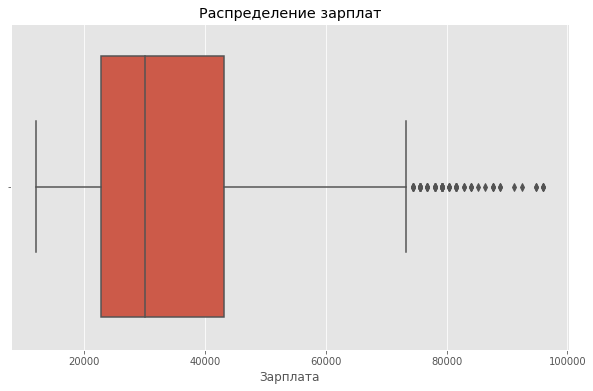

In [70]:
plt.rcParams["figure.figsize"] = (10, 6)

sns.boxplot(x='salary', data=train_quit);
plt.xlabel('Зарплата');
plt.title('Распределение зарплат');
plt.show()

In [71]:
all_test_quit = pd.merge(test_features, test_target_quit, on='id', how='inner')

Теперь проанализируем различные признаки в разрезе с **quit**

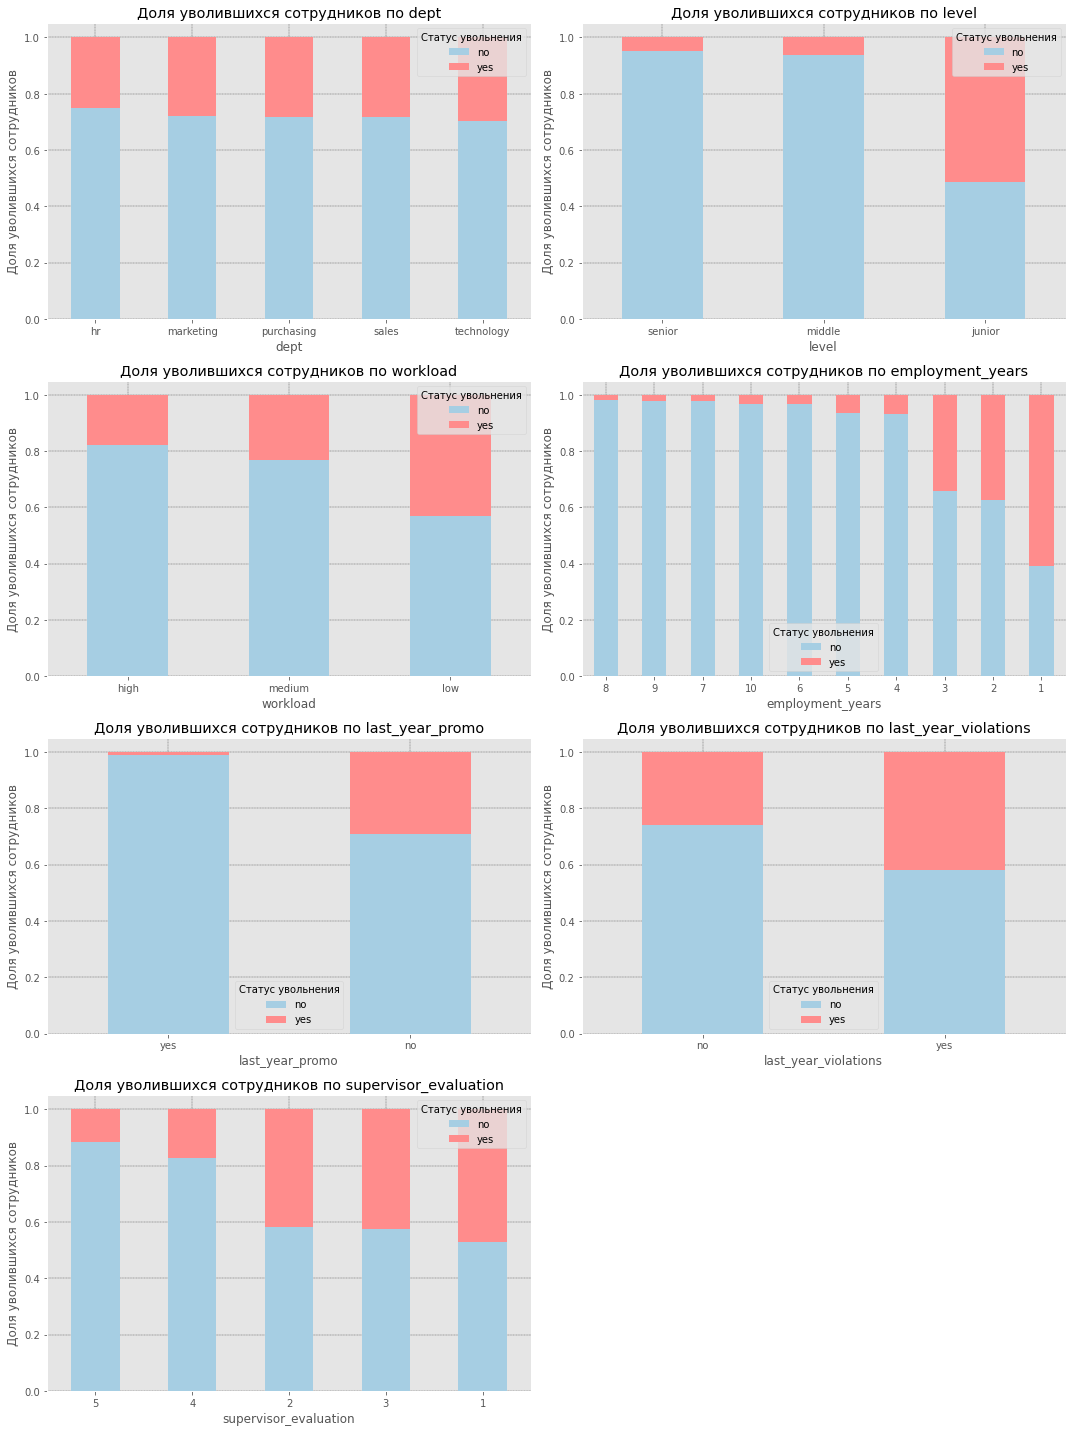

In [72]:
columns_to_plot = ['dept', 'level', 'workload', 'employment_years', 'last_year_promo', 
                   'last_year_violations', 'supervisor_evaluation']

num_rows = (len(columns_to_plot) + 1) // 2  # Расчет количества строк для сетки графиков
fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5*num_rows))  # Создание сетки графиков

# Светло-голубой и светло-красный цвета для графиков
colors = ['#a6cee3', '#ff8c8c'] 

for i, column in enumerate(columns_to_plot):
    row = i // 2
    col = i % 2
    ax = axes[row, col] if num_rows > 1 else axes[col]
    
    quit_by_column = train_quit.groupby(column)['quit'].value_counts(normalize=True).unstack()
    quit_by_column_sorted = quit_by_column.sort_values('no', ascending=False)
    quit_by_column_sorted.plot(kind='bar', stacked=True, ax=ax, color=colors)  # Применяем цвета
    
    ax.set_title(f'Доля уволившихся сотрудников по {column}')
    ax.set_xlabel(f'{column}')
    ax.set_ylabel('Доля уволившихся сотрудников')
    ax.legend(title='Статус увольнения')
    ax.grid(True, color='black', linestyle='--', linewidth=0.3)
    ax.tick_params(axis='x', rotation=0)
if len(columns_to_plot) % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show() 

In [73]:
def interactive_boxplot(df, column_names, yaxis_title='Значение наблюдения', xaxis_title='Наименование параметров', 
                        title_x=0.5, title_y=0.95, width=700, height=500,
                        xaxis_title_font=dict(family="Arial", size=14, color="Black"),
                        yaxis_title_font=dict(family="Arial", size=14, color="Black"),
                        title_font=dict(family="Arial", size=20, color="Black")):
    # Если передано одно имя столбца, преобразуем его в список для единообразия
    if not isinstance(column_names, list):
        column_names = [column_names]

    # Создаем интерактивный boxplot с Plotly Express для каждого столбца на одном графике
    fig = px.box(df, y=column_names, labels={'value': 'Values'}, points="all", width=width, height=height, boxmode='overlay')
    
    # Добавляем заголовок
    title_text = f"Интерактивный Boxplot для {', '.join(column_names)}"
    fig.update_layout(title_text=title_text, title_x=title_x, title_y=title_y,  
                      xaxis_title=xaxis_title, yaxis_title=yaxis_title,
                      xaxis_title_font=xaxis_title_font, yaxis_title_font=yaxis_title_font,
                      title_font=title_font)

    fig.show() 

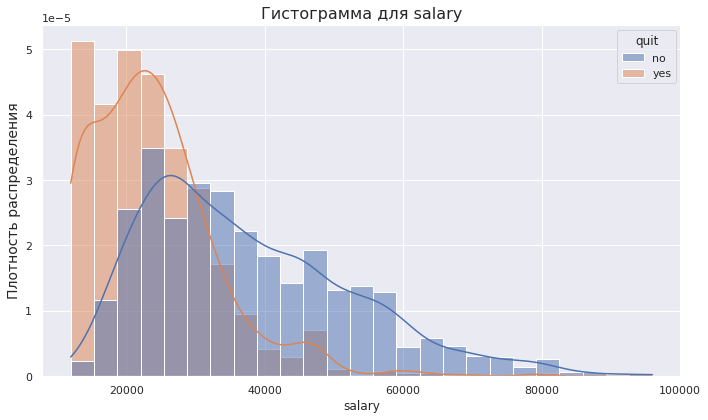

In [74]:
sns.set()
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Гистограмма для salary', fontsize=16)
ax.set_ylabel('Плотность распределения', fontsize=14)
sns.histplot(train_quit, x='salary', hue='quit', bins=25, kde=True, stat='density', common_norm=False, ax=ax)
plt.tight_layout()
plt.show()

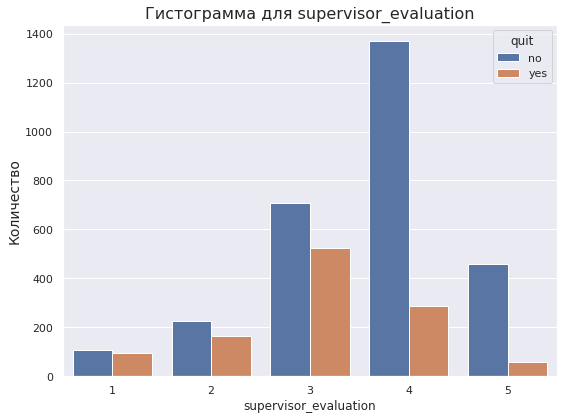

In [75]:
sns.set()
plt.figure(figsize=(8, 6))
sns.countplot(x='supervisor_evaluation', data=train_quit, hue='quit')
plt.title(f'Гистограмма для {column}', fontsize=16)
plt.ylabel('Количество', fontsize=14)
plt.tight_layout()
plt.show()

+ Закономерно из самых крупных отделов (**dept** и **technology**) пропорционально уволилось наибольшее кол-во сотрудников
+ На графике **level** сильно помог параметр kde. Можем заметить, что в основном люди уходят с позиции **junior** (у нас нет такой информации, но возможно какой-то процент **ушедших сотрудников** просто переходит на позицию **middle**)
+ Уволившихся сотрудников с **низкой** и **средней** загруженностью одинаковое кол-во
+ Логично, что людей, которые получили повышение и уволились, почти нет 
+ Из тех, кто нарушал трудовой договор, уволившихся работников немного меньше 
+ Можем заметить, что уволившиеся сотрудники зарабатывали значительно меньше
+ Закономерно большинство уволившихся работников получали в основном низкие оценки от работодателя 

Посмотрим средние зарплаты для **уволившихся** и **оставшихся сотрудников**

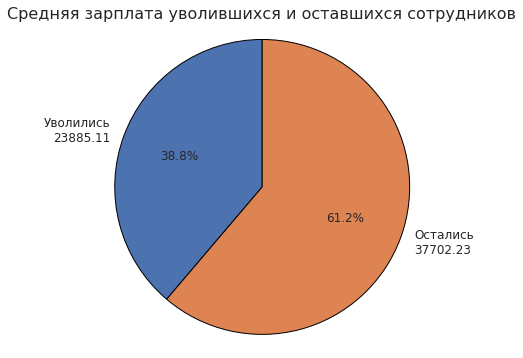

In [76]:
gone = train_quit['salary'][train_quit['quit'] == 'yes'].mean()
remained = train_quit['salary'][train_quit['quit'] == 'no'].mean()

data = [gone, remained]
labels = ['Уволились\n{:.2f}'.format(gone), 'Остались\n{:.2f}'.format(remained)]
plt.figure(figsize=(8, 6))
plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=90,
        wedgeprops={'edgecolor': 'black'}, textprops={'fontsize': 12})

plt.title('Средняя зарплата уволившихся и оставшихся сотрудников', fontsize=16)
plt.axis('equal')
plt.show()

Средняя зарплата **уволившихся** сотрудников - **23885**, у **оставшихся** - **37702**

Теперь вспомним про такой важный параметр как **job_satisfaction_rate**, который мы добавим в наш датафрейм и оценим его влияние на целевой признак **quit**

In [77]:
all_test_quit_res = pd.merge(all_test_quit, test_trg_job_stf, on='id', how='inner')

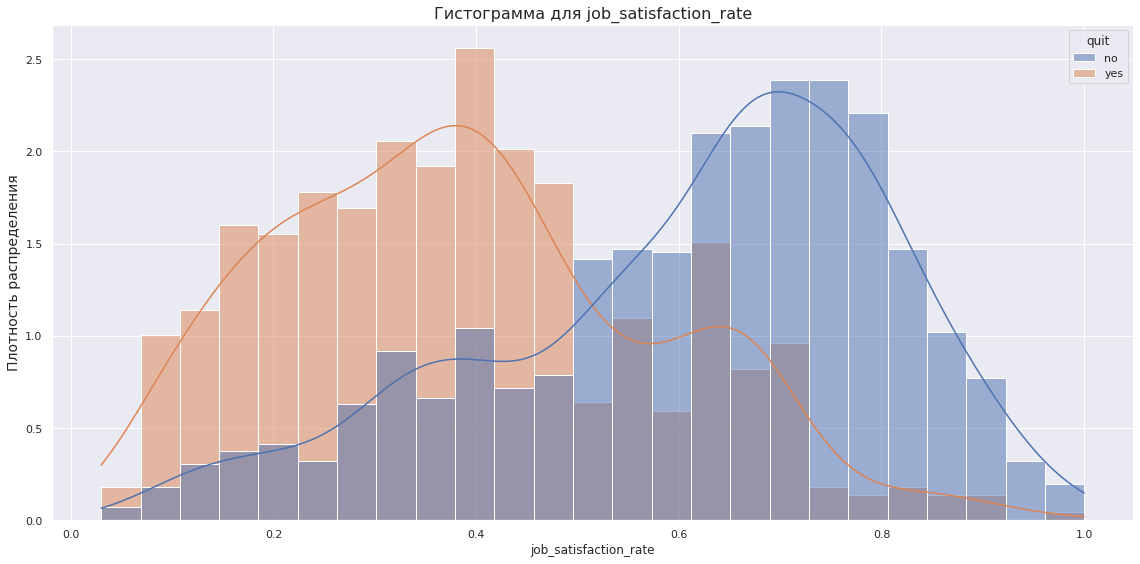

In [78]:
sns.set()
columns = ['job_satisfaction_rate']  # Не используется в этом случае
fig, axes = plt.subplots(1, 1, figsize=(16, 8))  # Изменяем на (1, 1)
col = columns[0]
axes.set_title(f'Гистограмма для {col}', fontsize=16)
axes.set_ylabel('Плотность распределения', fontsize=14)
sns.histplot(all_test_quit_res, bins=25, kde=True, ax=axes, hue='quit', stat='density', common_norm=False, x=col)  # Изменено на axes[0] 

plt.tight_layout()
plt.show()

Вполне ожидаемая картина, в основном увольняются сотрудники с низким коэффициентом **job_satisfaction_rate**, то есть мы можем подтвердить, что между двумя этими признаками есть сильная прямая корелляция

Проведем статистический тест для сравнения распределений в выборках, чтобы подтвердить вывод статистически 

**Нулевая гипотеза (H0):** Нет значимой разницы в уровне удовлетворенности работой между сотрудниками, которые ушли из компании, и теми, кто остался.

**Альтернативная гипотеза (H1):**  Существует значимая разница в уровне удовлетворенности работой между сотрудниками, которые ушли из компании, и теми, кто остался.

In [79]:
quit_group = all_test_quit_res[all_test_quit_res['quit'] == 'yes']['job_satisfaction_rate']
not_quit_group = all_test_quit_res[all_test_quit_res['quit'] == 'no']['job_satisfaction_rate']

ttest_result = stats.ttest_ind(quit_group, not_quit_group)

print(f"T-statistic value: {ttest_result.statistic}")


T-statistic value: -23.074784903634534


- Это значение показывает, насколько сильно отличаются средние значения двух групп
- Отрицательное значение означает, что среднее значение удовлетворенности работой для уволившихся сотрудников ниже, чем для не уволившихся.
- Абсолютная величина t-статистики **(23.0747)** довольно большая, что говорит о значительном различии между группами.

Так как T-statistic показал **(-23.0747)**,  который является отрицательным и, вероятно, имеет очень низкое значение p (меньше 0.05), мы можем предположить, что альтернативная гипотеза является более вероятной. Это означает, что уровень удовлетворенности работой у сотрудников, которые ушли из компании, **значительно ниже**, чем у тех, кто остался.

In [80]:
all_test_quit_res_copy = all_test_quit_res.copy()
all_test_quit_res_copy = all_test_quit_res_copy.drop(['id'], axis=1)

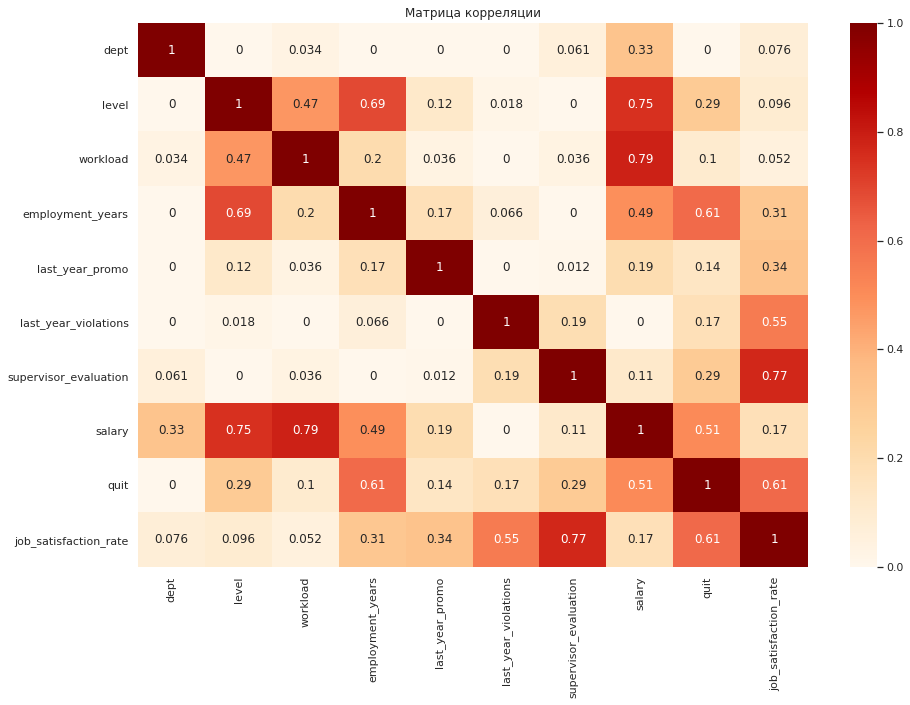

In [81]:
interval_cols = ['salary', 'job_satisfaction_rate'] 
corr_matrix = all_test_quit_res_copy.phik_matrix(interval_cols=interval_cols)
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='OrRd')
plt.title('Матрица корреляции')
plt.show()

1. **Уровень удовлетворенности работы и оценка руководителя (job_satisfaction_rate** и **supervisor_evaluation)**: Существует значительная положительная корреляция (0.77), что может означать, что высокая оценка руководителя сильно связана с высокой удовлетворенностью работой сотрудников.

2. **Удовлетворенность работы и наличие нарушений в прошлом году (job_satisfaction_rate** и **last_year_violations)**: Между этими параметрами также наблюдается существенная положительная корреляция (0.56), что указывает на то, что отсутствие нарушений может быть связано с более высокой удовлетворенностью работой.

3. **Зарплата и рабочая нагрузка (salary** и **workload)**: Здесь корреляция составляет 0.73, что является одним из самых сильных показателей связи в данной матрице. Это может свидетельствовать о том, что сотрудники с более высоким уровнем зарплаты обычно испытывают большую рабочую нагрузку.

4. **Зарплата и уровень должности (salary и level)**: Эти переменные имеют корреляцию 0.72, подчеркивая ожидаемую связь между более высокой зарплатой и более высоким карьерным уровнем внутри компании.

5. **Длительность работы и уровень должности (employment_years и level)**: Наблюдается достаточно сильная положительная корреляция в 0.69, что может указывать на то, что сотрудники на более высоких должностях, как правило, дольше работают в компании.

### Портрет уволившегося сотрудника

Теперь, когда мы исследовали все признаки, мы можем определить наиболее вероятный портрет уволившегося сотрудника 

+ Коэффициент уволившихся сотрудников примерно одинаков во всех отделах (за исключением **marketing**), но наиболее вероятно что наш сотрудник работает в отделе **sales**, так как это наиболее многочисленный отдел в абсолютном отношении
+ У нашего сотрудника квалификация **junior**
+ Вероятнее всего у нашего сотрудника **низкая** загруженность
+ Стаж скорее всего составляет один год
+ Соотвественно за последний год не было повышения и был нарушен трудовой договор
+ На удивление оценка работодателя составляет скорее **3**, нежели **2** или **1**
+ Рейтинг удовлетворения работой скорее всего составляет от **0** до **0.4**
+ Зарплата до **35000** 

## Добавление нового входного признака

Сейчас мы добавим в **train** датафрейм лучшие предсказарния **job_satisfaction_rate** из тренировочной выборки

In [85]:
train_quit['job_satisfaction_rate'] = best_model.predict(train_quit.drop(['id', 'quit'], axis=1))

In [86]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.646765
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.851538
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.357500
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.380000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.690000


In [87]:
train_quit.shape

(4000, 11)

Проделаем аналогичное для **test** выборки 

In [88]:
all_test_quit['job_satisfaction_rate'] = best_model.predict(X_test)

In [89]:
all_test_quit

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,no,0.866364
1,686555,hr,junior,medium,1,no,no,4,30000,no,0.670417
2,467458,sales,middle,low,5,no,no,4,19200,no,0.654000
3,418655,sales,middle,low,6,no,no,4,19200,no,0.655000
4,789145,hr,middle,medium,5,no,no,5,40800,no,0.832000
...,...,...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400,yes,0.505000
1996,109582,technology,middle,low,3,no,no,2,21600,yes,0.100000
1997,305653,technology,junior,low,1,no,no,3,14400,yes,0.240000
1998,160233,technology,middle,low,8,no,no,1,32400,no,0.580000


## Подготовка данных

In [90]:
all_test_quit.set_index('id')

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,no,0.866364
686555,hr,junior,medium,1,no,no,4,30000,no,0.670417
467458,sales,middle,low,5,no,no,4,19200,no,0.654000
418655,sales,middle,low,6,no,no,4,19200,no,0.655000
789145,hr,middle,medium,5,no,no,5,40800,no,0.832000
...,...,...,...,...,...,...,...,...,...,...
393147,marketing,junior,low,3,no,no,3,20400,yes,0.505000
109582,technology,middle,low,3,no,no,2,21600,yes,0.100000
305653,technology,junior,low,1,no,no,3,14400,yes,0.240000


In [91]:
#train_quit['quit'] = train_quit['quit'].apply(lambda x: 1 if x =='yes' else 0)

In [92]:
train_2 = train_quit.drop(['id'], axis=1)
train_2.drop_duplicates(inplace=True)

test_2 = all_test_quit.drop(['quit'], axis=1)
target_2 = all_test_quit['quit'] 

In [93]:
label_encoder = LabelEncoder()

In [94]:
train_quit['quit'] = label_encoder.fit_transform(train_quit['quit'])

In [95]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train = train_2.drop('quit', axis=1)
y_train = train_2['quit'] 
X_test = test_2
y_test = label_encoder.transform(target_2)
#y_test = target_2

ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']
 
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error'))
    ]
)

In [96]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'], 
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [97]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier())
])

### Вывод

+ Данные были разделены на тренировочную и тестовые выборки **train_2** и **test_2**

+ Собраны все преобразователи для различных типов признаков с помощью **ColumnTransformer**. Категориальные признаки были закодированы с использованием методов **OneHotEncoder** и **OrdinalEncoder**, численные признаки были масштабированы с помощью **StandardScaler**. Все остальные признаки остались без изменений.

+ Реализован сам пайплайн

## Обучение модели

In [98]:
param_grid = [
     {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 13),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
    
]

In [99]:
grid_search_quit = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search_quit.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         ['dept',
                                                                          'last_year_promo',
                                                                          'last_year_violations']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('simpleImputer_before_ord',
                                                                                          SimpleImp...
             param_grid=[{'models': [KNeighborsClassifier()],
                          'models__n_neighbors': range(2, 13),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [DecisionTreeClassifier(random_state=42)],
                          'models__max_depth': range(2, 15),
                          'models__max_features': range(2, 15),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='roc_auc')

In [100]:
print('Лучшая модель и её параметры:\n\n', grid_search_quit.best_estimator_)
print("---------------------------------------------------------------------------------------")
print('Параметры лучшей модели:', grid_search_quit.best_params_)
print("---------------------------------------------------------------------------------------")
print('Метрика лучшей модели по кросс-валидации на обучающих данных:', grid_search_quit.best_score_)
print("---------------------------------------------------------------------------------------")

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent...
                                 

In [101]:
best_model = grid_search_quit.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
test_roc_auc = round(roc_auc_score(y_test, y_pred_proba), 2)

print(f"ROC AUC score на тестовых данных: {test_roc_auc}")

ROC AUC score на тестовых данных: 0.92


На основе метрики **ROC-AUC** была отобрана лучшая модель **{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 5, 'models__max_features': 1**. Получена метрика ROC-AUC на тестовой выборке со значением **0.9225**, что полностью удовлетворяет требованию поиска не менее **0.91**. 

Проверка модели на адекватность с помощью **DummyClassifier**

In [102]:
dummy_model_2 = DummyClassifier(random_state=RANDOM_STATE)

# Обучаем DummyClassifier на тренировочных данных
dummy_model_2.fit(X_train, y_train)

# Предсказываем вероятности принадлежности к положительному классу с помощью DummyClassifier на тестовых данных
dummy_model_probas = dummy_model_2.predict_proba(X_test)[:,1]

# Вычисляем ROC-AUC с помощью DummyClassifier на тестовых данных
dummy_roc = roc_auc_score(y_test, dummy_model_probas)
print('ROC-AUC =', round(dummy_roc, 2))
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_pred_proba), 2)}')

ROC-AUC = 0.5
Метрика ROC-AUC на тестовой выборке: 0.92


## Анализ важности признаков и их отбор

In [103]:
X_train_encoded = grid_search_quit.best_estimator_['preprocessor'].fit_transform(X_train)
feature_names = grid_search_quit.best_estimator_['preprocessor'].get_feature_names_out()
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=feature_names)
X_train_sample = shap.utils.sample(X_train_encoded_df, 100)
explainer = shap.KernelExplainer(grid_search_quit.best_estimator_.named_steps['models'].predict_proba, X_train_sample)
shap_values = explainer(X_train_sample)

  0%|          | 0/100 [00:00<?, ?it/s]

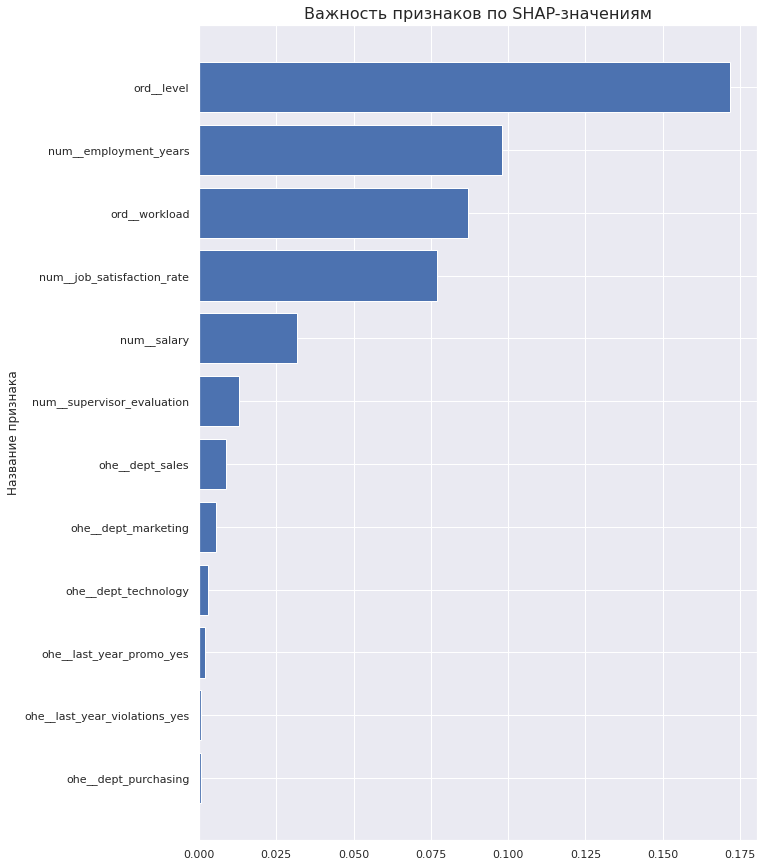

In [104]:
df_shap = pd.DataFrame(shap_values[:, :, 1].values, columns=feature_names)

for column in feature_names:
    df_shap[column] = df_shap[column].abs()

mean_df = df_shap.mean().reset_index()
mean_df.columns = ['Признак', 'SHAP-значение']
mean_df = mean_df.sort_values(
    by='SHAP-значение',
)

plt.figure(figsize=(10, 15))
plt.barh(
    mean_df['Признак'],
    mean_df['SHAP-значение'],
) 

plt.ylabel('Название признака') 
plt.title('Важность признаков по SHAP-значениям', fontsize=16)

plt.show()

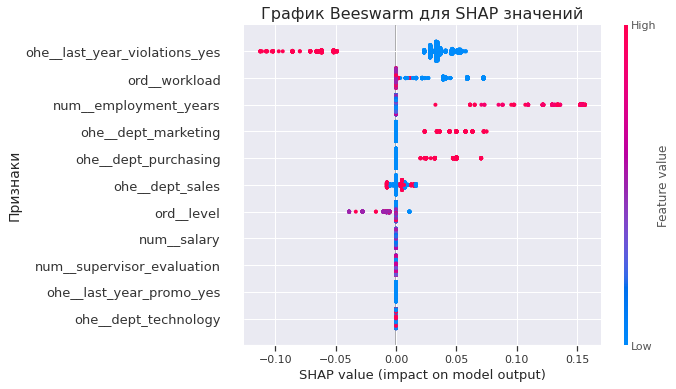

In [105]:
plt.xlabel("SHAP значения", fontsize=14)
plt.ylabel("Признаки", fontsize=14)
plt.title("График Beeswarm для SHAP значений", fontsize=16)

plt.style.use("ggplot")

plt.show(shap.plots.beeswarm(shap_values_pipe, max_display=12))

### Вывод

1. Наиболее значимые признаки:

+ **supervisor_evaluation:** Высокие оценки работы сотрудника руководством снижают вероятность того, что сотрудник уволится
+ **employment_years:** Больший стаж работы сотрудника снижает шанс его ухода из компании
+ **level:** Чем выше вкалификация сотрудника, тем ниже шанс, что он уволится 
+ **salary:** Аналогичная корелляция с зарплатой 


2. Средняя значимость:
+ **last_year_violations_yes, remainder_job_satisfaction_rate_pred:** Эти признаки имеют меньший вклад в модель, но всё же влияют на предсказание.

3. Наименее значимые признаки:
+ **last_year_promo_yes, dept_sales, dept_technology, dept_marketing, workload, dept_purchasing:** Признаки с наименьшим вкладом в модель. Они оказывают отрицательное влияние на предсказание, и их вклад в модель минимален.
Менее значимые признаки можно рассмотреть для исключения из модели.

## Итоговый вывод

В ходе проекта были рассмотрены задачи, связанные с предсказанием удовлетворенности сотрудников и вероятности их увольнения из компании. Эти задачи являются критически важными для **HR-отделов** многих компаний, поскольку помогают принимать обоснованные решения для повышения лояльности сотрудников и снижения текучести кадров.


### Этапы работы

1. **Предварительный анализ данных:** На начальном этапе был проведен анализ данных, включая оценку пропусков, выбросов и корреляции между признаками. Это позволило определить ключевые переменные и первичную обработку данных.

2. **Подготовка данных:** Обработка пропущенных значений, кодирование категориальных переменных и нормализация числовых данных для обучения моделей.

3. **Выбор модели:** Были выбраны и опробованы различные модели машинного обучения, включая линейные модели, деревья решений и ансамблевые методы. Для каждой задачи был проведен поиск по сетке для оптимизации гиперпараметров.

4. **Оценка моделей:** Модели оценивались на основе кросс-валидации с использованием метрик, подходящих для задачи (например, ROC-AUC).

5. **Анализ важности признаков:** Был проведен анализ для определения ключевых признаков, влияющих на удовлетворенность сотрудников и вероятность их увольнения.

### Выводы по решению задач

**Задача 1:** Предсказание уровня удовлетворённости сотрудника Для предсказания уровня удовлетворенности сотрудников была выбрана модель **DecisionTreeRegressor** с гиперпараметрами **(max_depth=12, max_features=10, random_state=42)**. Для числовых признаков было применено стандартизация (StandardScaler()). Эта модель показала хорошую способность к обобщению и высокую точность предсказаний, что делает ее подходящей для анализа удовлетворенности сотрудников. Она позволила выделить ключевые факторы, влияющие на уровень удовлетворенности, и предоставила **HR-отделу** инструмент для прогнозирования потенциальных проблем в коллективе.

**Задача 2:** Предсказание увольнения сотрудника из компании Во второй задаче лучшим решением стала модель на основе **DecisionTreeClassifier** **(random_state=42, 'models__max_depth': 5, 'models__max_features': 1)**. Эта модель демонстрирует высокую эффективность в предсказании увольнений сотрудников, благодаря чему компания может заранее определять риски потери ключевых сотрудников и предпринимать меры по их удержанию.

### Выводы и предложения для бизнеса 

+ **Высокая точность моделей:** Достигнута высокая точность предсказаний, что подтверждает возможность использования данных моделей в реальных бизнес-процессах.
+ **Важность анализа удовлетворенности:** Анализ удовлетворенности сотрудников и их склонности к увольнению позволит HR-отделам предпринимать своевременные меры для улучшения рабочей среды и удержания ценных кадров.
+ **Персонализация HR-инициатив:** Использование моделей машинного обучения дает возможность разработки персонализированных подходов к каждому сотруднику, основанных на предсказаниях их удовлетворенности и потенциальной увольнительной активности.
+ **Предложения для бизнеса:**
  + Рекомендуется внедрение системы регулярного мониторинга удовлетворенности сотрудников с использованием предложенных моделей, а также разработка программ лояльности и мотивации для снижения текучести кадров.
  + Также необходимо из данных убрать сотрудников которые могли попасть под сокращение, так как, эти данные искажают реальную картину на предприятии.

Проект демонстрирует, как данные и алгоритмы машинного обучения могут быть эффективно использованы для решения важных **HR-задач**, способствуя улучшению рабочей атмосферы и снижению уровня увольнений в компании